# Importer Test

Run tests to ensure that all importer functions are working as intended. Let's start by defining some helper functions. 

In [1]:
import matplotlib.pyplot as plt

def show_depth(img):
    plt.imshow(img, cmap='Greys')

## Creating the importer
Create a new `DepthImporter` object using the path to the dataset.

In [2]:
import sys
sys.path.append("..")

from src.data.importers import NYUImporter

#dataset_path = "/media/alex/VLM Backup (WX21D77DF8KT)/nyu_hand_dataset_v2/"
dataset_path = "/home/alex/dev/datasets/NYU/dataset/"

data_importer = NYUImporter(dataset_path, use_cache=False)

## Loading a sample
Let's load and view a sample depth image.

718.0


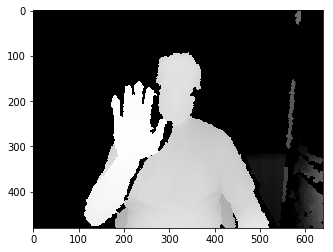

In [3]:
file_path = dataset_path + "train/depth_1_0000001.png"

img_data = data_importer.load_depth_data(file_path)

show_depth(img_data)
print(img_data.min())

## Loading the annotations

Now that a sample is loaded, we need to load the corresponding joint annotations.

In [4]:
import scipy.io

train_file = "{}/train/joint_data.mat".format(data_importer.base_path)
mat_file = scipy.io.loadmat(train_file)
joints3D = mat_file['joint_xyz'][0][0]
joints2D = mat_file['joint_uvd'][0][0]
print(joints3D.shape)

(36, 3)


Let's get the ground truth joints that we are concerned with (the ones in `data_importer.evaluated_joints`

In [5]:
import numpy as np

num_joints = len(data_importer.evaluated_joints)

joints2D_gt = np.zeros((num_joints, 3), np.float32)
for idx, val in enumerate(data_importer.evaluated_joints):
    joints2D_gt[idx, 0] = joints2D[val, 0]
    joints2D_gt[idx, 1] = joints2D[val, 1]
    joints2D_gt[idx, 2] = joints2D[val, 2]
    
joints3D_gt = np.zeros((num_joints, 3), np.float32)
for idx, val in enumerate(data_importer.evaluated_joints):
    joints3D_gt[idx, 0] = joints3D[val, 0]
    joints3D_gt[idx, 1] = joints3D[val, 1]
    joints3D_gt[idx, 2] = joints3D[val, 2]
    
print(joints2D_gt)
print(joints3D_gt)

[[180.12895 195.42758 731.0689 ]
 [185.69302 228.00754 741.1159 ]
 [212.4804  172.75383 737.744  ]
 [207.64732 211.90805 746.9333 ]
 [234.63535 164.74454 741.1971 ]
 [226.31418 206.42291 755.62775]
 [257.07202 176.4456  740.67175]
 [251.1273  214.33078 754.7238 ]
 [283.74005 250.08482 730.20856]
 [279.66415 265.65515 740.0853 ]
 [262.53848 291.40384 752.3917 ]
 [196.49666 322.16144 767.7335 ]
 [222.8492  328.51862 768.33765]
 [223.30292 266.85678 761.4926 ]]
[[-173.89279    55.50484   731.0689  ]
 [-169.27005    15.139128  741.1159  ]
 [-134.8928     84.504456  737.744   ]
 [-142.71205    35.741276  746.9333  ]
 [-107.59875    95.01192   741.1971  ]
 [-120.38634    43.217266  755.62775 ]
 [ -79.26199    80.18216   740.67175 ]
 [ -88.395584   32.99948   754.7238  ]
 [ -45.026638  -12.543582  730.20856 ]
 [ -50.76547   -32.341694  740.0853  ]
 [ -73.521866  -65.87884   752.3917  ]
 [-161.2444   -107.44468   767.7335  ]
 [-126.93867  -115.84921   768.33765 ]
 [-125.22023   -34.83582   761

## Hand Detection
With the image and annotations loaded, the hand can now be cropped to produce the final training image. Since we have annotations, there is no need to perform Center of Mass calculations.

[223.30292 266.85678 761.4926 ]


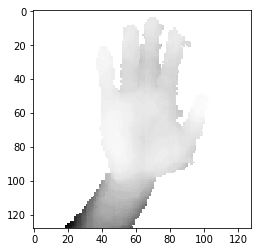

In [27]:
from src.util.hand_detector import HandDetector

hd = HandDetector(img_data, data_importer.fx, data_importer.fy, data_importer)

# use the last joint as the center of mass
com = joints2D_gt[-1]
print(com)

cropped_hand = hd.crop_area_3d(com, size=(300, 300, 300))

# subtract the min so the depth image is displayed clearer
cropped_hand[cropped_hand != 0] -= cropped_hand[cropped_hand != 0].min()

show_depth(cropped_hand)

The annotations should match the cropped hands.

In [32]:
com3d = np.zeros(com.shape)
com3d[0] = com[0] * com[2] / data_importer.fx
com3d[1] = com[1] * com[2] / data_importer.fy
com3d[2] = com[2]

joints3d_norm = joints3D_gt - com3d
print(joints3d_norm)

[[-463.06769035 -290.63696294  -30.42370605]
 [-458.44494865 -331.00267606  -20.37670898]
 [-424.06770561 -261.63734822  -23.74859619]
 [-431.88694999 -310.400528    -14.55932617]
 [-396.77364586 -251.12988667  -20.29553223]
 [-409.56123588 -302.92453771   -5.86486816]
 [-368.43689201 -265.95964436  -20.82086182]
 [-377.57048271 -313.14232259   -6.76879883]
 [-334.20153663 -358.68538575  -31.28405762]
 [-339.9403672  -378.48349767  -21.4072876 ]
 [-362.69676445 -412.02064137   -9.10089111]
 [-450.41929863 -453.58648305    6.24090576]
 [-416.1135659  -461.99101643    6.84503174]
 [-414.3951287  -380.97762303    0.        ]]
